In [1]:
from astropy.table import Table
import numpy as np
import pandas as pd
from astropy.cosmology import Planck18 as cosmo
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FuncFormatter
from matplotlib.ticker import ScalarFormatter
import healpy as hp
from pylab import cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
import os
plot_dir = "../plots"
os.makedirs(plot_dir, exist_ok=True)  # Create the directory if it doesn't exist

data=Table.read('data/quaia_G20.0.fits')
print(f"column names: {data.columns}")

column names: <TableColumns names=('source_id','unwise_objid','redshift_quaia','redshift_quaia_err','ra','dec','l','b','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','mag_w1_vg','mag_w2_vg','pm','pmra','pmdec','pmra_error','pmdec_error')>


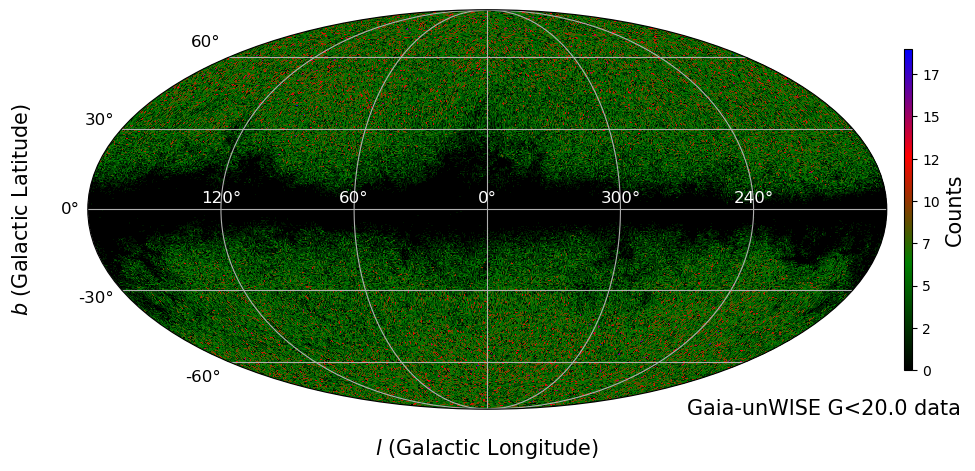

In [2]:
df1=pd.DataFrame(data['l'])
df2=pd.DataFrame(data['b'])
df3=pd.DataFrame(data['redshift_quaia'])
df4=pd.DataFrame(data['phot_g_mean_mag'])

df=pd.concat([df1,df2,df3,df4],axis=1,join='inner')
df.columns=['l','b','redshift','g_mag']

##########################################################################
l=df['l'].to_numpy()
b=df['b'].to_numpy()
Z=df['redshift'].to_numpy()

r=cosmo.comoving_distance(Z).value
theta = np.radians(90 - b)
phi = np.radians(l)

df5 = pd.DataFrame(data = theta)
df6 = pd.DataFrame(data = phi)
df7 = pd.DataFrame(data = r)
df8=pd.concat([df7,df5,df6,df1,df2,df3],axis=1,join='inner')
df8.columns=['r','theta','phi','l','b','redshift']

###########################################################################################################

r = df8['r'].to_numpy()    # in Mpc
th = df8['theta'].to_numpy()
ph = df8['phi'].to_numpy()

# visualization of whole data using HEALPix with nside of 128
nside1 = 128
npix1 = hp.nside2npix(nside1)  # 12 * nside^2

m1 = np.zeros(npix1)
for j in range(len(theta)):
    px1=hp.ang2pix(nside1,theta[j],phi[j])
    
    m1[px1] += 1

m1min, m1max = np.min(m1),np.max(m1)

custom_cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("custom",["black","green","red","blue"])
hp.projview(m1, coord=["G"], cbar=False, cmap=custom_cmap1, graticule=True,
            graticule_labels=True, projection_type="mollweide", 
            longitude_grid_spacing=60, latitude_grid_spacing=30, xtick_label_color='white', 
            ytick_label_color='black', graticule_color=None)

plt.xlabel(r"$l$ (Galactic Longitude)", fontsize=15, labelpad=20)  # X-axis label
plt.ylabel(r"$b$ (Galactic Latitude)", fontsize=15, labelpad=20)   # Y-axis label

plt.text(0.75, 0.00, "Gaia-unWISE G<20.0 data", fontsize=15, color='black',
         ha='left', va='center', transform=plt.gca().transAxes)


norm1 = Normalize(vmin=np.min(m1), vmax=np.max(m1))

cax1 = plt.axes([1.0, 0.2, 0.01, 0.6])  # [left, bottom, width, height]

color_bar1 = ColorbarBase(cax1, cmap=custom_cmap1, norm=norm1, orientation='vertical')
color_bar1.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x)}"))

color_bar1.set_label('Counts', fontsize=15)
plt.savefig('../plots/mollview_quasar_20.pdf', dpi=600, bbox_inches='tight')
plt.show()



# count vs redshift plot

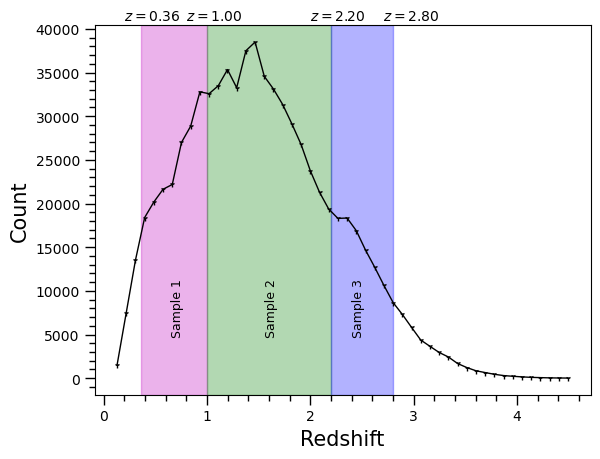

In [3]:
bin_no = 50
bin_edg = np.linspace(np.min(Z), np.max(Z), bin_no + 1)
bin_cent = (bin_edg[:-1] + bin_edg[1:]) / 2
NN, __ = np.histogram(Z, bins=50)

fig, ax = plt.subplots()
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('Redshift', fontsize=15)

ax.plot(bin_cent,NN,ls='-',lw = 1,marker='1',markersize=4,color='k')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=1)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4, color='k')

ax.axvspan(0.36, 1.00, color='m', alpha=0.3, label = 'Sample 1')
ax.axvspan(1.00,2.20, color='g', alpha=0.3, label = 'Sample 2')
ax.axvspan(2.20,2.80, color='b', alpha=0.3, label = 'Sample 3')

ax.text(0.20,41000, r"$z=0.36$", fontsize=10, color='black')
ax.text(0.80,41000, r"$z=1.00$", fontsize=10, color='black')
ax.text(2.00,41000, r"$z=2.20$", fontsize=10, color='black')
ax.text(2.70,41000, r"$z=2.80$", fontsize=10, color='black')


ax.text(0.65,5000, 'Sample 1', fontsize=9, color='black', rotation=90)
ax.text(1.56,5000, 'Sample 2', fontsize=9, color='black', rotation=90)
ax.text(2.4,5000, 'Sample 3', fontsize=9, color='black', rotation=90)

#ax.legend(fontsize=8, frameon=False)
plt.savefig('../plots/count_vs_z.pdf', bbox_inches='tight')
plt.show()

# quasar number density vs radial distance

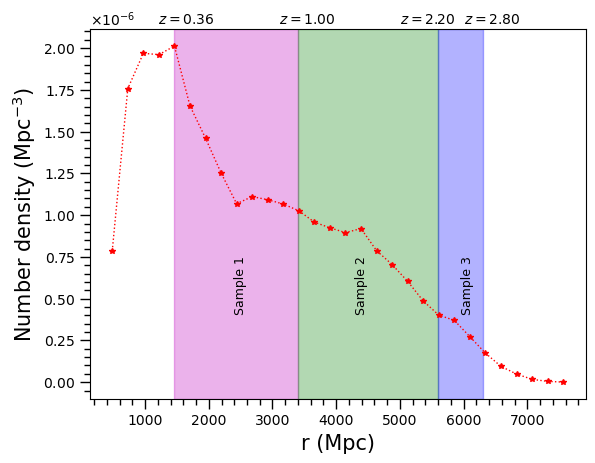

In [4]:
###############################################################################################
nbin = 30
bin_edges = np.linspace(np.min(r), np.max(r), nbin + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
dr = bin_edges[1] - bin_edges[0]

# Bin the data and compute counts
N, _ = np.histogram(r, bins=30)

# Compute volumes and densities
v = (4 / 3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)
d = N / v
R = bin_centers

fig, ax = plt.subplots()
ax.set_ylabel(r"Number density (Mpc$^{-3}$)", fontsize=15)
ax.set_xlabel('r (Mpc)', fontsize=15)

ax.plot(R,d,ls=':',lw=1,marker='*',markersize=4,color='r')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=1)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4, color='k')
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-1, 1))  
ax.yaxis.set_major_formatter(formatter)

x1 = cosmo.comoving_distance(0.36).value
x2 = cosmo.comoving_distance(1).value

x3 = cosmo.comoving_distance(2.2).value
x4 = cosmo.comoving_distance(2.8).value
# ax.axvline(x=x1, color='m', linestyle='--', linewidth=1)
# ax.axvline(x=x2, color='g', linestyle='--', linewidth=1)
# ax.axvline(x=x3, color='b', linestyle='-.', linewidth=1)
# ax.axvline(x=x4, color='b', linestyle='-.', linewidth=1)
ax.text(1200,2.15*10**(-6), r"$z=0.36$", fontsize=10, color='black')
ax.text(3100,2.15*10**(-6), r"$z=1.00$", fontsize=10, color='black')

ax.text(5000,2.15*10**(-6), r"$z=2.20$", fontsize=10, color='black')
ax.text(6000,2.15*10**(-6), r"$z=2.80$", fontsize=10, color='black')

ax.axvspan(x1, x2, color='m', alpha=0.3, label = 'Sample 1')
ax.axvspan(x2, x3, color='g', alpha=0.3, label = 'Sample 2')
ax.axvspan(x3, x4, color='b', alpha=0.3, label = 'Sample 3')

ax.text(2400,np.max(d)*0.21, 'Sample 1', fontsize=9, color='black', rotation=90)
ax.text(4300, np.max(d)*0.21,'Sample 2', fontsize=9, color='black', rotation=90)
ax.text(5950,np.max(d)*0.21,'Sample 3', fontsize=9, color='black', rotation=90)


#ax.legend(fontsize=8, frameon=False)
plt.savefig('../plots/number_density.pdf', bbox_inches='tight')
#plt.show()


In [5]:
#############################################
df9 = df8[(df8['redshift']<1.0) & (df8['redshift']>=0.36)]
df9.to_csv("data/quasar_sample_1.csv", index = False)

df10 = df8[(df8['redshift']<2.20) & (df8['redshift']>=1.0)]
df10.to_csv("data/quasar_sample_2.csv", index = False)

df11 = df8[(df8['redshift']<=2.80) & (df8['redshift']>=2.20)]
df11.to_csv("data/quasar_sample_3.csv", index = False)

##############################################

# visualization of quasar sample 1 with nside = 8

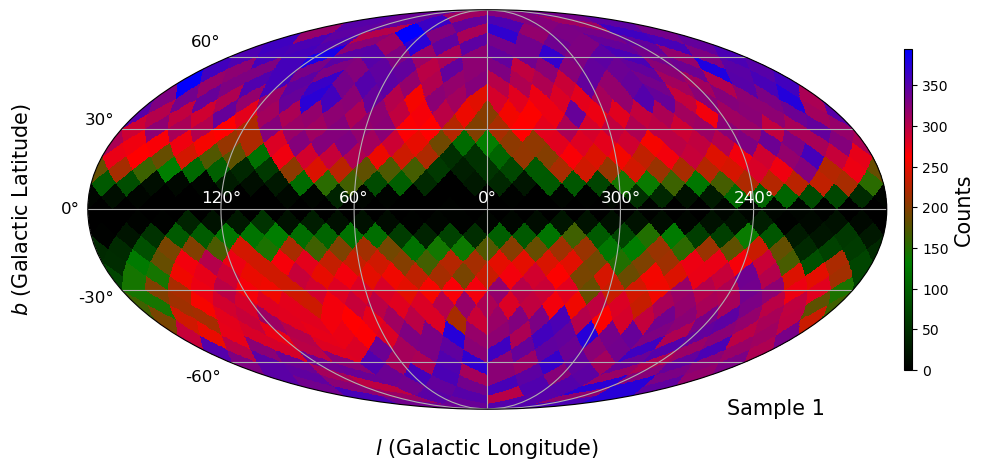

In [6]:

th2 = df9['theta'].to_numpy()
ph2 = df9['phi'].to_numpy()

nside = 8
npix = hp.nside2npix(nside)  # 12 * nside^2

m = np.zeros(npix)
for j in range(len(th2)):
    px=hp.ang2pix(nside,th2[j],ph2[j])
    
    m[px] += 1
    
mmin, mmax = np.min(m),np.max(m)


custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom",["black","green","red","blue"])
hp.projview(m, coord=["G"], cbar=False, cmap=custom_cmap, graticule=True,
            graticule_labels=True, projection_type="mollweide", 
            longitude_grid_spacing=60, latitude_grid_spacing=30, xtick_label_color='white', 
            ytick_label_color='black', graticule_color=None)

plt.xlabel(r"$l$ (Galactic Longitude)", fontsize=15, labelpad=20)  
plt.ylabel(r"$b$ (Galactic Latitude)", fontsize=15, labelpad=20)   

plt.text(0.8, 0.00, "Sample 1", fontsize=15, color='black',
         ha='left', va='center', transform=plt.gca().transAxes)

norm = Normalize(vmin=np.min(m), vmax=np.max(m))

cax = plt.axes([1.0, 0.2, 0.01, 0.6])  

color_bar = ColorbarBase(cax, cmap=custom_cmap, norm=norm, orientation='vertical')

color_bar.set_label('Counts', fontsize=15)
plt.savefig('../plots/mollview_sample1.pdf', dpi=600, bbox_inches='tight')
plt.show()